In [0]:
# RUN THIS LINE ONLY ONCE !!!
import sys
import os
os.chdir('../')
sys.path.append(os.getcwd())

In [ ]:
from utils import get_dataset, validate
from learner import Learner
from schedulers import CyclicLRDecay
import random
import torch
import torch.nn as nn
from torch.optim import AdamW
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.get_device_name(device)

In [0]:
# If you have dark theme
from matplotlib.pyplot import rcParams
rcParams['figure.facecolor'] = 'white'

In [0]:
# Setup logger
import logging
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(levelname)s : %(message)s', datefmt='%m/%d/%Y %I:%M:%S %p')

In [6]:
dataset, test_dataset, emb_weights = get_dataset(min_freq=5, test_set=True)
dataset.fields['review'].include_lengths = True

random.seed(35)
ds_train, ds_val = dataset.split(split_ratio=[0.9, 0.1])

06/10/2020 05:21:28 PM INFO : ----- IMDb dataset -----
06/10/2020 05:21:28 PM INFO : Downloading data
06/10/2020 05:21:36 PM INFO : Untar data
06/10/2020 05:21:42 PM INFO : Processing the training set
06/10/2020 05:21:42 PM INFO : Processing the test set
06/10/2020 05:21:47 PM INFO : Building training dataset
06/10/2020 05:22:21 PM INFO : Building vocab
06/10/2020 05:22:21 PM INFO : Downloading vectors from http://nlp.stanford.edu/data/glove.840B.300d.zip
.vector_cache/glove.840B.300d.zip: 2.18GB [16:57, 2.14MB/s]                           
06/10/2020 05:39:18 PM INFO : Extracting vectors into .vector_cache
06/10/2020 05:41:12 PM INFO : Loading vectors from .vector_cache/glove.840B.300d.txt
100%|█████████▉| 2194912/2196017 [04:15<00:00, 11138.21it/s]06/10/2020 05:48:12 PM INFO : Building test dataset


<br>

### GRU with a concat pooling layer

In [0]:
class GRUConcatPool(nn.Module):
    def __init__(self, embed_vecs=None, hidden_size=512, dropout=(0, 0, 0)):
        super().__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding.from_pretrained(embed_vecs)

        self.gru = nn.GRU(input_size=emb_weights.size()[1], hidden_size=hidden_size,
                          num_layers=1, bidirectional=True, batch_first=True)
        self.emb_dropout = nn.Dropout(p=dropout[0])
        self.dropout = nn.Dropout(p=dropout[1])
        self.head = nn.Sequential(
            nn.Linear(4*self.hidden_size, 2*self.hidden_size),
            # nn.BatchNorm1d(3*self.hidden_size),
            nn.Dropout(p=dropout[2]),
            nn.ReLU(),
            nn.Linear(2*self.hidden_size, 2)
        )
        
    def forward(self, batch):
        batch, lengths = batch
        batch_dim, _ = batch.shape
        
        embedded = self.emb_dropout(self.embedding(batch))
        embedded_packed = nn.utils.rnn.pack_padded_sequence(embedded, lengths, batch_first=True, enforce_sorted=False)
        
        outputs_packed, hiddens = self.gru(embedded_packed)
        outputs, lengths = nn.utils.rnn.pad_packed_sequence(outputs_packed, batch_first=True)
        outputs = self.dropout(outputs) # B x L x 2H

        # masking
        mask = torch.zeros_like(outputs, dtype=torch.bool)
        for i, length in enumerate(lengths):
            mask[i, length:, :] = True

        # outputs.masked_fill_(mask, 0) # B x L x 2H
        # this first masking is not necessary because pad_padded_sequence already
        # padded with zeros
        avg_pool = torch.sum(outputs, dim=1)/lengths.unsqueeze(1).to(device) # B x 2H

        outputs.masked_fill_(mask, -float('inf')) # B x L x 2H
        max_pool = torch.max(outputs, dim=1)[0] # B x 2H

        cat_output = torch.cat([avg_pool, max_pool], dim=1) # B x 6H

        logging.debug('batch shape : {}'.format(batch.shape))
        logging.debug('embedding shape : {}'.format(embedded.shape))
        logging.debug('hiddens shape : {}'.format(hiddens.shape))
        logging.debug('outputs shape : {}'.format(outputs.shape))
        logging.debug('avg_pool shape : {}'.format(avg_pool.shape))
        logging.debug('max_pool shape : {}'.format(max_pool.shape))
        
        return self.head(cat_output)

In [0]:
model = GRUConcatPool(emb_weights.clone(), hidden_size=512, dropout=(0.65, 0.65, 0.65)).to(device)
loss_fn = nn.CrossEntropyLoss().to(device)
optimiser = AdamW(model.parameters(), weight_decay=1e-3)
cycle_steps = (len(ds_train)//64 + 1)
scheduler = CyclicLRDecay(optimiser, 5e-5, 4e-3, cycle_steps, 0.1, gamma_factor=0.75)
learner = Learner(model, loss_fn, optimiser, scheduler, ds_train, ds_val, device)

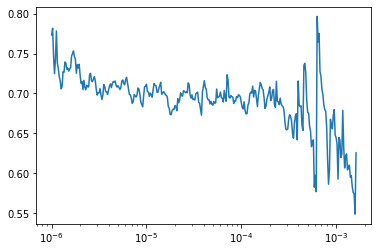

In [9]:
learner.lr_finder(bs=64, lr_range=(1e-6, 1e-2))

In [10]:
learner.train(epochs=2, bs=64, grad_clip=(0.4, 5))

06/10/2020 05:51:16 PM INFO : Epoch : 1, batch : 88, train_loss = 0.7326, val_loss = 0.5271, val_accuracy : 0.749, time = 16s
06/10/2020 05:51:34 PM INFO : Epoch : 1, batch : 176, train_loss = 0.4443, val_loss = 0.3598, val_accuracy : 0.857, time = 34s
06/10/2020 05:51:51 PM INFO : Epoch : 1, batch : 264, train_loss = 0.3791, val_loss = 0.3526, val_accuracy : 0.866, time = 51s
06/10/2020 05:52:09 PM INFO : Epoch : 1, batch : 352, train_loss = 0.3719, val_loss = 0.3455, val_accuracy : 0.860, time = 68s
06/10/2020 05:52:26 PM INFO : Epoch : 2, batch : 88, train_loss = 0.3945, val_loss = 0.3109, val_accuracy : 0.874, time = 86s
06/10/2020 05:52:43 PM INFO : Epoch : 2, batch : 176, train_loss = 0.3554, val_loss = 0.3034, val_accuracy : 0.869, time = 103s
06/10/2020 05:53:00 PM INFO : Epoch : 2, batch : 264, train_loss = 0.3610, val_loss = 0.3305, val_accuracy : 0.874, time = 120s
06/10/2020 05:53:17 PM INFO : Epoch : 2, batch : 352, train_loss = 0.3326, val_loss = 0.3179, val_accuracy : 0.

In [11]:
model.embedding.weight.requires_grad_(True);
learner.train(epochs=6, bs=64, grad_clip=(0.4, 5))

06/10/2020 05:53:34 PM INFO : Epoch : 1, batch : 88, train_loss = 0.3295, val_loss = 0.3115, val_accuracy : 0.881, time = 17s
06/10/2020 05:53:53 PM INFO : Epoch : 1, batch : 176, train_loss = 0.3006, val_loss = 0.2784, val_accuracy : 0.904, time = 35s
06/10/2020 05:54:10 PM INFO : Epoch : 1, batch : 264, train_loss = 0.2702, val_loss = 0.2702, val_accuracy : 0.902, time = 53s
06/10/2020 05:54:28 PM INFO : Epoch : 1, batch : 352, train_loss = 0.2843, val_loss = 0.2784, val_accuracy : 0.901, time = 71s
06/10/2020 05:54:46 PM INFO : Epoch : 2, batch : 88, train_loss = 0.2449, val_loss = 0.2473, val_accuracy : 0.904, time = 88s
06/10/2020 05:55:04 PM INFO : Epoch : 2, batch : 176, train_loss = 0.2337, val_loss = 0.2426, val_accuracy : 0.911, time = 106s
06/10/2020 05:55:21 PM INFO : Epoch : 2, batch : 264, train_loss = 0.2401, val_loss = 0.2467, val_accuracy : 0.908, time = 124s
06/10/2020 05:55:39 PM INFO : Epoch : 2, batch : 352, train_loss = 0.2199, val_loss = 0.2560, val_accuracy : 0.

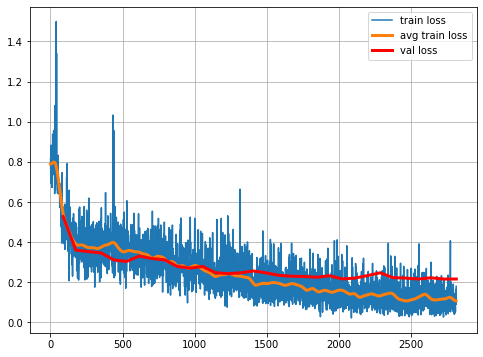

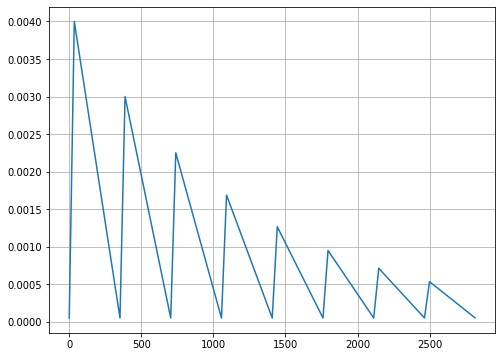

In [12]:
learner.recorder.plot_losses(show_lr=True)

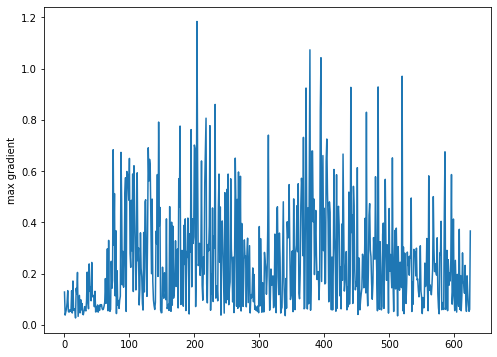

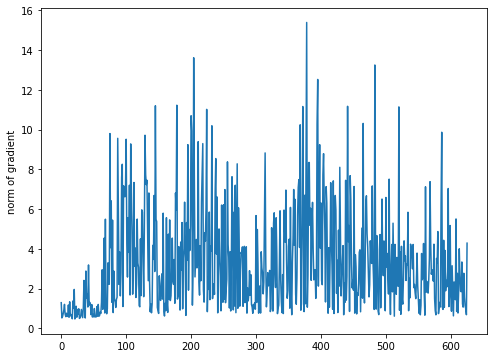

In [0]:
learner.recorder.plot_grads()

In [13]:
print('Test loss : {:.5f}, test accuracy : {:.03f}'.format(*validate(test_dataset, loss_fn, model, 64)))

Test loss : 0.22870, test accuracy : 0.908


In [0]:
if not os.path.exists('models'):
    os.makedirs('models')
torch.save(model.state_dict(), 'models/model_GRU_concatpool.pt')

<br>

### GRU with self-attention

In [0]:
class SelfAttention(nn.Module):
    def __init__(self, query_dim, n_outputs):
        super().__init__()
        self.W1 = nn.Linear(query_dim, query_dim//2, bias=False)
        self.W2 = nn.Linear(query_dim//2, n_outputs, bias=False)
        self.softmax = nn.Softmax(dim=2)

    def forward(self, query, lengths):
        attn_weights = self.W2(torch.tanh(self.W1(query)))
        attn_weights = attn_weights.permute(0, 2, 1)

        mask = torch.zeros_like(attn_weights, dtype=torch.bool)
        for i, length in enumerate(lengths):
            mask[i, :, length:] = True
        attn_weights.masked_fill_(mask, -float('inf'))

        return self.softmax(attn_weights)

In [0]:
class GRUSelfAttention2(nn.Module):
    def __init__(self, embed_vecs=None, hidden_size=256, attn_output_size=8, dropout=(0, 0, 0)):
        super().__init__()
        self.hidden_size = hidden_size
        self.attn_output_size = attn_output_size
        self.embedding = nn.Embedding.from_pretrained(embed_vecs)

        self.gru = nn.GRU(input_size=emb_weights.size()[1], hidden_size=hidden_size,
                          num_layers=1, bidirectional=True, batch_first=True)
        self.emb_dropout = nn.Dropout(p=dropout[0])
        self.dropout = nn.Dropout(p=dropout[1])
        self.attention = SelfAttention(2*self.hidden_size, attn_output_size)
        self.head = nn.Sequential(
            nn.Linear(2*self.attn_output_size*self.hidden_size, self.attn_output_size*self.hidden_size),
            nn.Dropout(p=dropout[2]),
            nn.ReLU(),
            nn.Linear(self.attn_output_size*self.hidden_size, 2))
        
    def forward(self, batch):
        batch, lengths = batch
        batch_dim, _ = batch.shape
        
        embedded = self.emb_dropout(self.embedding(batch)) # B x L x E

        embedded_packed = nn.utils.rnn.pack_padded_sequence(embedded, lengths, batch_first=True, enforce_sorted=False)
        outputs_packed, hiddens = self.gru(embedded_packed)
        outputs, lengths = nn.utils.rnn.pad_packed_sequence(outputs_packed, batch_first=True)
        outputs = self.dropout(outputs) # B x L x 2H
        
        attn_weights = self.attention(outputs, lengths) # B x A x L
        attn_output = torch.bmm(attn_weights, outputs).view(batch_dim, -1) # B x A*2H
        
        logging.debug('batch shape : {}'.format(batch.shape))
        logging.debug('embedding shape : {}'.format(embedded.shape))
        logging.debug('hiddens shape : {}'.format(hiddens.shape))
        logging.debug('outputs shape : {}'.format(outputs.shape))
        logging.debug('attn_weights shape : {}'.format(attn_weights.shape))
        logging.debug('attn_output shape : {}'.format(attn_output.shape))
        
        return self.head(attn_output)

In [0]:
class Hook():
    def __init__(self, module):
        self.hook = module.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output):
        self.output = output

In [0]:
class CrossEntropyWP(nn.Module):
  def __init__(self, attn_size, hook, penalty=0):
    super().__init__()
    self.crossentropy = nn.CrossEntropyLoss()
    self.eye = torch.eye(attn_size).to(device)
    self.hook = hook
    self.penalty = penalty

  def forward(self, model_output, label):
    loss = self.crossentropy(model_output, label)

    attn_matrix = self.hook.output
    logging.debug('attn_matrix shape : {}'.format(attn_matrix.size()))
    penalty_term = torch.bmm(attn_matrix, attn_matrix.transpose(1, 2))
    penalty_term = torch.norm(penalty_term - self.eye, dim=(1, 2)).pow(2).mean()

    loss += self.penalty * penalty_term
    return loss

In [0]:
model = GRUSelfAttention2(emb_weights.clone(), hidden_size=256, attn_output_size=8,
                          dropout=(0.5, 0.5, 0.5)).to(device)
loss_fn = CrossEntropyWP(attn_size=8, hook=Hook(model.attention), penalty=0.03).to(device)
optimiser = AdamW(model.parameters(), weight_decay=1e-3)
cycle_steps = (len(ds_train)//64 + 1)
scheduler = CyclicLRDecay(optimiser, 2e-5, 1e-3, cycle_steps, 0.1, gamma_factor=0.85)
learner = Learner(model, loss_fn, optimiser, scheduler, ds_train, ds_val, device)

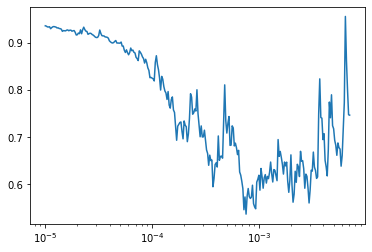

In [20]:
learner.lr_finder(bs=64, lr_range=(1e-5, 1e-1))

In [24]:
learner.train(epochs=2, bs=64, grad_clip=(0.15, 1.5))

06/10/2020 06:13:04 PM INFO : Epoch : 1, batch : 88, train_loss = 0.7638, val_loss = 0.6026, val_accuracy : 0.844, time = 8s
06/10/2020 06:13:12 PM INFO : Epoch : 1, batch : 176, train_loss = 0.6072, val_loss = 0.5402, val_accuracy : 0.879, time = 17s
06/10/2020 06:13:21 PM INFO : Epoch : 1, batch : 264, train_loss = 0.5552, val_loss = 0.5383, val_accuracy : 0.865, time = 25s
06/10/2020 06:13:29 PM INFO : Epoch : 1, batch : 352, train_loss = 0.5457, val_loss = 0.5190, val_accuracy : 0.879, time = 34s
06/10/2020 06:13:38 PM INFO : Epoch : 2, batch : 88, train_loss = 0.5501, val_loss = 0.5260, val_accuracy : 0.873, time = 42s
06/10/2020 06:13:46 PM INFO : Epoch : 2, batch : 176, train_loss = 0.5259, val_loss = 0.5227, val_accuracy : 0.882, time = 51s
06/10/2020 06:13:54 PM INFO : Epoch : 2, batch : 264, train_loss = 0.5387, val_loss = 0.4891, val_accuracy : 0.882, time = 59s
06/10/2020 06:14:03 PM INFO : Epoch : 2, batch : 352, train_loss = 0.5157, val_loss = 0.4915, val_accuracy : 0.879

In [25]:
model.embedding.weight.requires_grad_(True);
learner.train(epochs=6, bs=64, grad_clip=(0.15, 1.5))

06/10/2020 06:14:12 PM INFO : Epoch : 1, batch : 88, train_loss = 0.5088, val_loss = 0.4850, val_accuracy : 0.885, time = 9s
06/10/2020 06:14:22 PM INFO : Epoch : 1, batch : 176, train_loss = 0.4916, val_loss = 0.5060, val_accuracy : 0.877, time = 18s
06/10/2020 06:14:30 PM INFO : Epoch : 1, batch : 264, train_loss = 0.4804, val_loss = 0.4735, val_accuracy : 0.889, time = 27s
06/10/2020 06:14:40 PM INFO : Epoch : 1, batch : 352, train_loss = 0.4787, val_loss = 0.4658, val_accuracy : 0.898, time = 36s
06/10/2020 06:14:49 PM INFO : Epoch : 2, batch : 88, train_loss = 0.4518, val_loss = 0.5077, val_accuracy : 0.886, time = 45s
06/10/2020 06:14:58 PM INFO : Epoch : 2, batch : 176, train_loss = 0.4469, val_loss = 0.4843, val_accuracy : 0.892, time = 54s
06/10/2020 06:15:07 PM INFO : Epoch : 2, batch : 264, train_loss = 0.4556, val_loss = 0.4528, val_accuracy : 0.902, time = 63s
06/10/2020 06:15:15 PM INFO : Epoch : 2, batch : 352, train_loss = 0.4320, val_loss = 0.4489, val_accuracy : 0.903

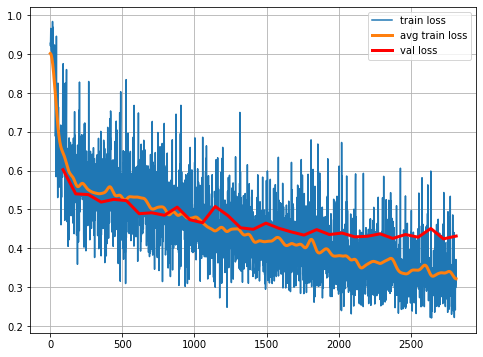

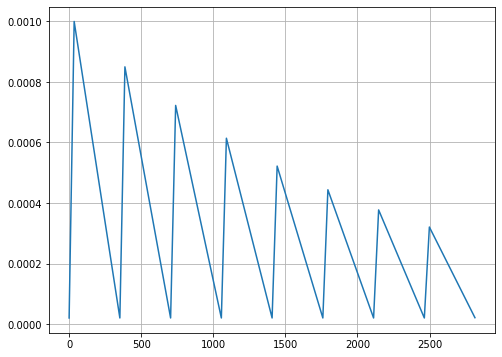

In [26]:
learner.recorder.plot_losses(show_lr=True)

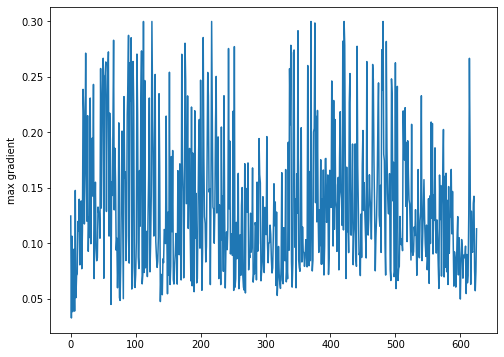

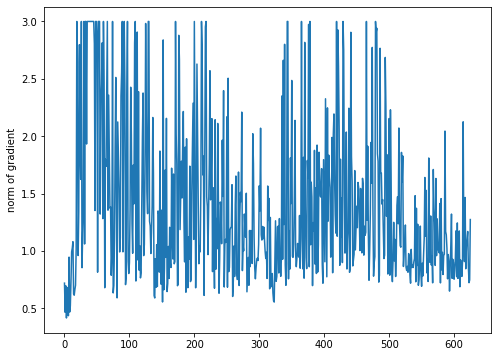

In [0]:
learner.recorder.plot_grads()

In [27]:
print('Test loss : {:.5f}, test accuracy : {:.03f}'.format(*validate(test_dataset, loss_fn, model, bs=64)))

Test loss : 0.40941, test accuracy : 0.916


In [0]:
if not os.path.exists('models'):
    os.makedirs('models')
torch.save(model.state_dict(), 'models/model_GRU_selfattention.pt')

<br>

In [0]:
from IPython.core.display import HTML

def weighted_colour(words, weights):
    text = "<h3>"
    for word, weight in zip(words, weights):
        weight = (1 - weight) * 256
        text += "<span style='background-color: rgb({}); color: black'> {} </span>".format("256,"+str(weight)+","+str(weight), word)
    text += "</h3>"
    return text

In [0]:
from torchtext.data import Iterator
iterator = iter(Iterator(test_dataset, 1, shuffle=False, device=device))
model.eval();
hook = Hook(model.attention)

In [0]:
batch = next(iterator)
model(batch.review)
attn_weights = hook.output

In [52]:
word_list = [test_dataset.fields['review'].vocab.itos[index] for index in batch.review[0].squeeze(0).tolist()]
weights = attn_weights.data.squeeze(0).mean(dim=0).tolist()
weights = [weight/max(weights) for weight in weights]

HTML(weighted_colour(word_list, weights))

In [54]:
word_list = [test_dataset.fields['review'].vocab.itos[index] for index in batch.review[0].squeeze(0).tolist()]
weights = attn_weights.data.squeeze(0).mean(dim=0).tolist()
weights = [weight/max(weights) for weight in weights]

HTML(weighted_colour(word_list, weights))

In [58]:
word_list = [test_dataset.fields['review'].vocab.itos[index] for index in batch.review[0].squeeze(0).tolist()]
weights = attn_weights.data.squeeze(0).mean(dim=0).tolist()
weights = [weight/max(weights) for weight in weights]

HTML(weighted_colour(word_list, weights))